In [41]:
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from lightgbm import LGBMClassifier, log_evaluation, early_stopping

rc = {
    "axes.facecolor": "#2E3440",
    "figure.facecolor": "#2E3440",
    "axes.edgecolor": "#4C566A",
    "grid.color": "#4C566A",
    "font.family": "JetBrains Mono",
    "text.color": "#FFFFFF",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 8,
    "legend.title_fontsize": 8
}
sns.set(rc=rc)

In [2]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')

orig_df = pd.read_csv('original.csv')
orig_df[orig_df == '?'] = np.nan
orig_df.dropna(inplace=True)
orig_df[['uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']] = orig_df[['uniq_Op', 'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount']].astype('float64')

target_var = 'defects'
cat_features = []
num_features = test_df.columns

[ ] Outlier handling <br>
[ ] Numerical Transformation

In [59]:
train_df.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


## Shape and Columns

In [35]:
print('Train Descriptors')
print(f'Shape: {train_df.shape}')
print(f'Columns : {train_df.columns}')
print('')
print('Test Descriptors')
print(f'Shape: {test_df.shape}')
print(test_df.columns)

Train Descriptors
Shape: (101763, 22)
Columns : Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount', 'defects'],
      dtype='object')

Test Descriptors
Shape: (67842, 21)
Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
       'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
       'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
      dtype='object')


## Missing Values

In [5]:
null_values = {'column': [], 'train_null_values': [], 'test_null_values': []}

for col in test_df.columns:
    train_col_null = train_df[col].isna().sum()
    test_col_null = test_df[col].isna().sum()
    
    null_values['column'].append(col)
    null_values['train_null_values'].append(train_col_null)
    null_values['test_null_values'].append(test_col_null)

null_values = pd.DataFrame(null_values)
null_values['train_total'] = train_df.shape[0]
null_values['test_total'] = test_df.shape[0]
null_values['train_null_perc'] = null_values['train_null_values'] / null_values['train_total']
null_values['test_null_perc'] = null_values['test_null_values'] / null_values['test_total']
null_values.sort_values(by='train_null_perc', inplace=True, ascending=False)

null_values

,column,train_null_values,test_null_values,train_total,test_total,train_null_perc,test_null_perc
0,loc,0,0,101763,67842,0.0,0.0
11,t,0,0,101763,67842,0.0,0.0
19,total_Opnd,0,0,101763,67842,0.0,0.0
18,total_Op,0,0,101763,67842,0.0,0.0
17,uniq_Opnd,0,0,101763,67842,0.0,0.0
16,uniq_Op,0,0,101763,67842,0.0,0.0
15,locCodeAndComment,0,0,101763,67842,0.0,0.0
14,lOBlank,0,0,101763,67842,0.0,0.0
13,lOComment,0,0,101763,67842,0.0,0.0
12,lOCode,0,0,101763,67842,0.0,0.0


In [6]:
null_values_per_row = train_df.isna().sum(axis=1)
pd.DataFrame(null_values_per_row.value_counts().sort_index())

,0
0,101763


## Adversarial Testing

### Train vs Test

In [33]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

-----> Fold 1 <-----
: AUC ROC = 0.5012120499948575
-----> Fold 2 <-----
: AUC ROC = 0.5007656307605985
-----> Fold 3 <-----
: AUC ROC = 0.5033691627229224
-----> Fold 4 <-----
: AUC ROC = 0.5022088418314361
-----> Fold 5 <-----
: AUC ROC = 0.5038751196862419
--> Overall results for out of fold predictions
: AUC ROC = 0.5016389173461654


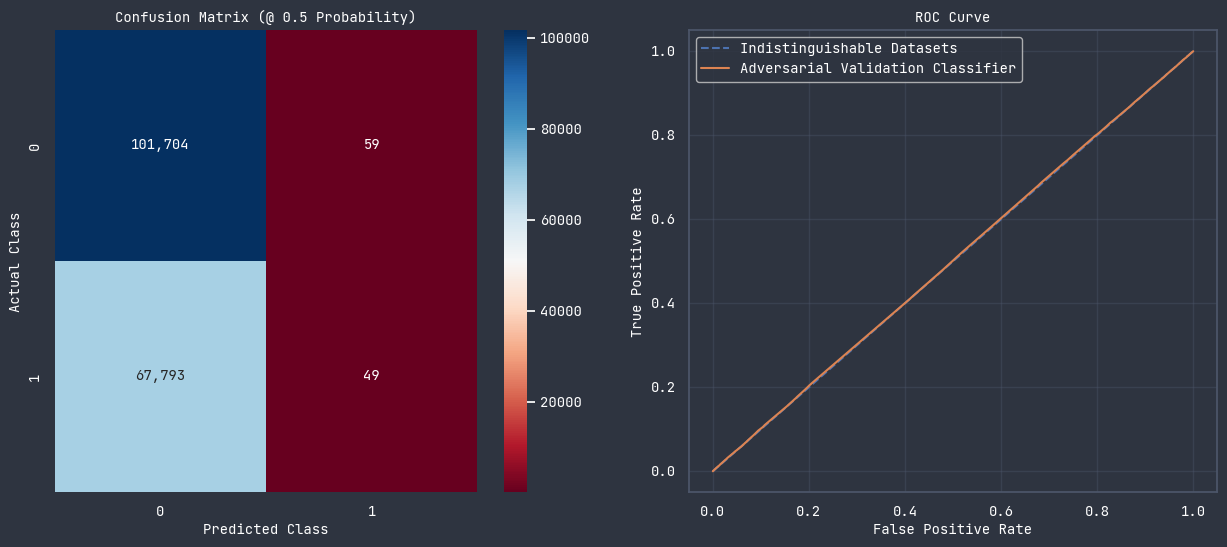

In [35]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

### Train/Test Original

In [36]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=0), orig_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

-----> Fold 1 <-----
: AUC ROC = 0.6628720829786185
-----> Fold 2 <-----
: AUC ROC = 0.6688092180429941
-----> Fold 3 <-----
: AUC ROC = 0.684070224137506
-----> Fold 4 <-----
: AUC ROC = 0.6767370775268534
-----> Fold 5 <-----
: AUC ROC = 0.6864908734012518
--> Overall results for out of fold predictions
: AUC ROC = 0.6756072370577311


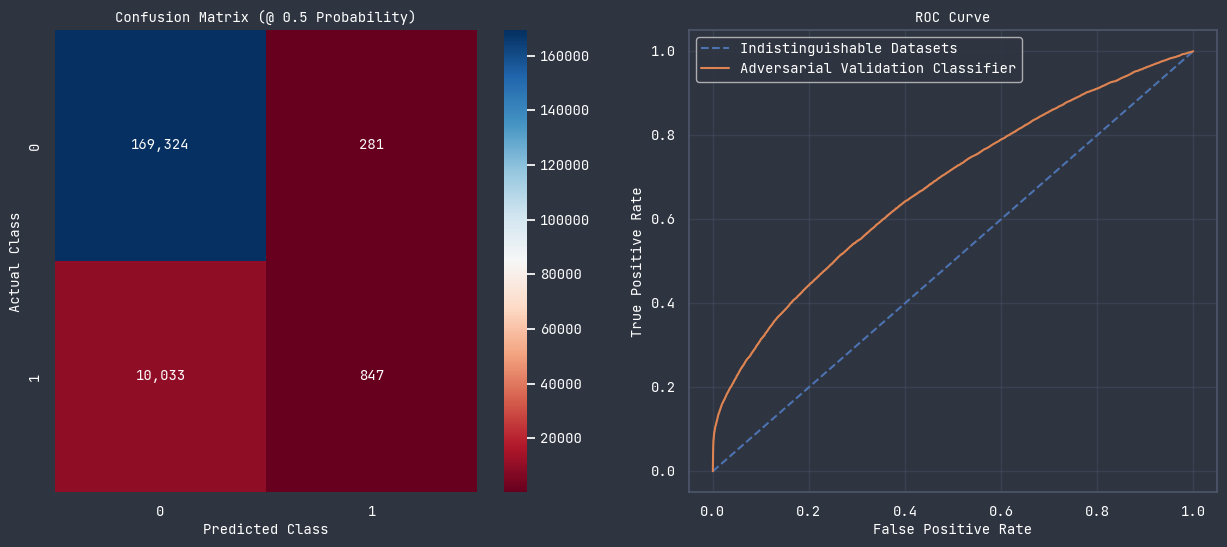

In [37]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

# Exploratory Data Analysis

## Variable Distribution

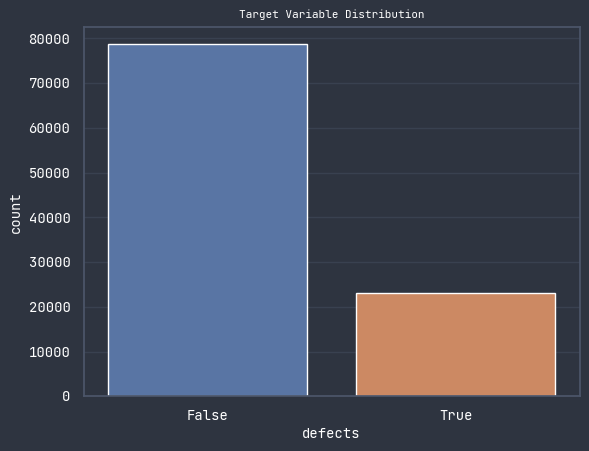

In [38]:
sns.countplot(data=train_df, x=target_var)
plt.title('Target Variable Distribution', fontsize=8)
plt.show()

## Variable Correlation

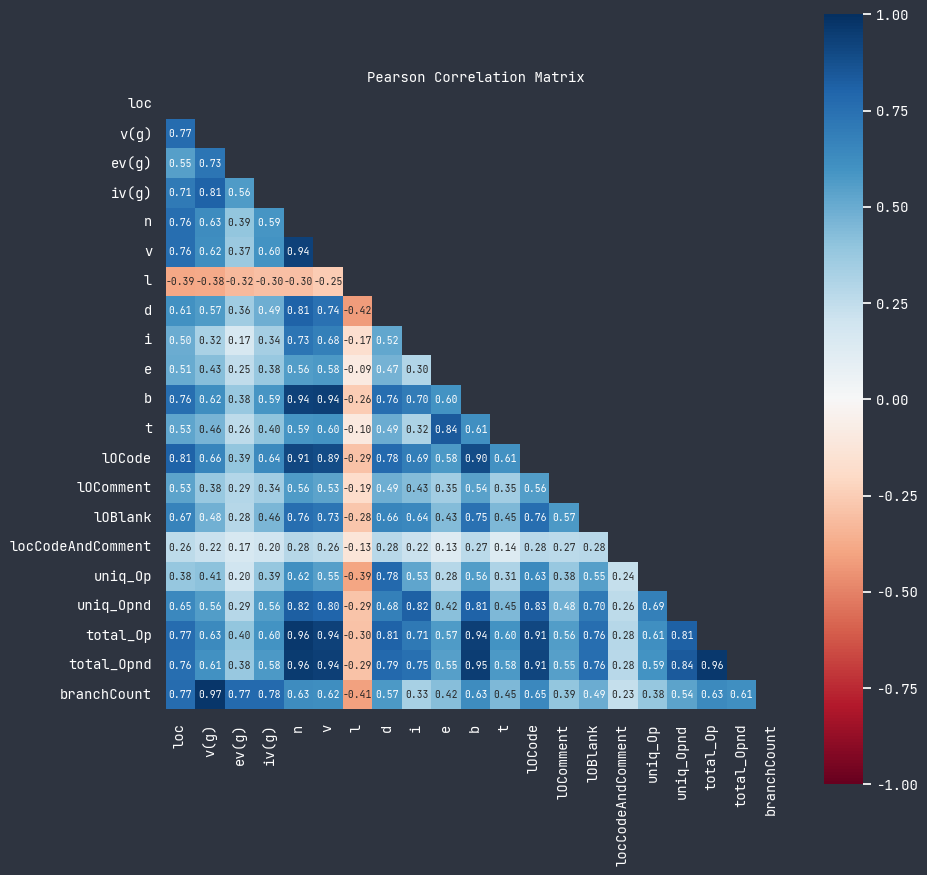

In [43]:
df = pd.concat([train_df[test_df.columns], test_df], ignore_index=True)
df_corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, mask=mask, annot=True, annot_kws={"size": 7}, fmt='.2f', cmap='RdBu', square=True, vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix')
plt.show()

## Numerical Variables

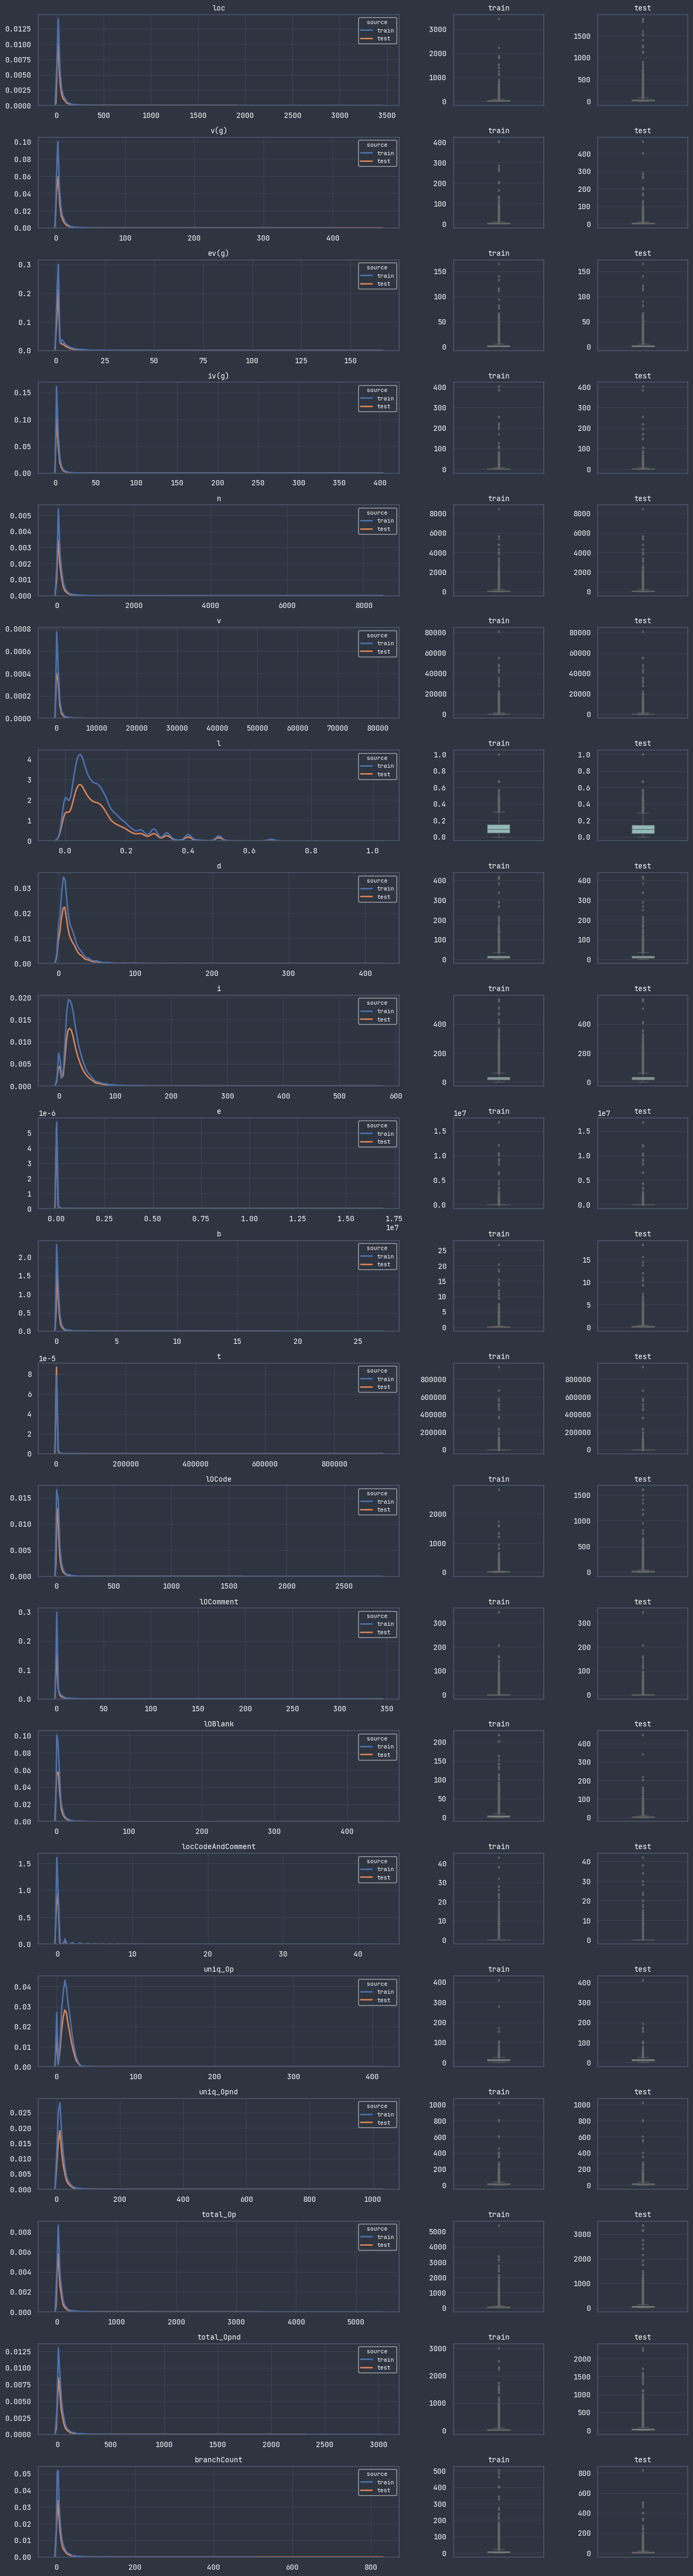

In [45]:
df = pd.concat([train_df[num_features].assign(source='train'), test_df[num_features].assign(source='test')], ignore_index=True)

fig, axs = plt.subplots(nrows=len(num_features), ncols=3, figsize=(16, len(num_features) * 3),
                        gridspec_kw= {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.8, 0.2, 0.2]})

for i, feat in enumerate(num_features):
    sns.kdeplot(data=df[[feat, 'source']], x=feat, hue='source', linewidth=2, ax=axs[i, 0])
    axs[i, 0].set_title(feat)
    axs[i, 0].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'train', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, color='#8FBCBB', ax=axs[i, 1])
    axs[i, 1].set_title('train')
    axs[i, 1].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'test', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, color='#8FBCBB', ax=axs[i, 2])
    axs[i, 2].set_title('test')
    axs[i, 2].set(xlabel='', ylabel='')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [9]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)

target_map = {False: 0, True: 1}

params = {
    'map_target': True
}


if params['map_target']:
    combined_df[target_var] = combined_df[target_var].map(target_map)


cleaned_train_df = combined_df[~combined_df[target_var].isnull()]
cleaned_test_df = combined_df[combined_df[target_var].isnull()].drop(target_var, axis=1)

In [10]:
cleaned_train_df

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,0.0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,0.0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,0.0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,1.0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101758,10.0,2.0,1.0,1.0,28.0,122.98,0.15,6.60,18.63,811.70,...,7,0,1,0,11.0,8.0,16.0,12.0,3.0,0.0
101759,27.0,5.0,4.0,1.0,107.0,559.93,0.06,18.00,34.17,11268.27,...,23,0,2,0,18.0,20.0,67.0,40.0,9.0,0.0
101760,26.0,1.0,1.0,1.0,83.0,360.17,0.04,22.75,12.56,5893.69,...,20,0,4,0,10.0,8.0,51.0,28.0,1.0,0.0
101761,10.0,2.0,1.0,2.0,43.0,191.76,0.15,6.46,29.53,1534.04,...,7,0,1,0,11.0,14.0,24.0,19.0,3.0,0.0


# Model Evaluation

In [22]:
# Cross Fold Training
n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((cleaned_train_df.shape[0],))
oof_metric = []

final_train_df = cleaned_train_df.drop(target_var, axis=1)
target = cleaned_train_df[target_var]

for fold, (train_idx, test_idx) in enumerate(k_fold.split(final_train_df, target)):
    X_train, X_valid = pd.DataFrame(final_train_df.iloc[train_idx]), pd.DataFrame(final_train_df.iloc[test_idx])
    y_train, y_valid = target.iloc[train_idx], target.iloc[test_idx]
    
    model = LGBMClassifier(
        n_estimators=1000,
        max_depth=10,
        random_state=2023,
        verbose=-1
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        eval_metric='auc',
        callbacks=[
            log_evaluation(0),
            early_stopping(50, verbose=0)
        ]
    )
    
    oof_preds = model.predict_proba(X_valid)[:, 1]
    train_oof_preds[test_idx] = oof_preds
    oof_metric.append(roc_auc_score(y_valid, oof_preds))
    
oof_metric = np.array(oof_metric)
overall_metric = roc_auc_score(target, train_oof_preds)
print(f'OOF Scores: {oof_metric}')
print(f'Mean Score: {oof_metric.mean()}')
print(f'Standard Deviation: {oof_metric.std()}')
print('')
print(f'Overall Result: {overall_metric}')
print('')
print(f'{oof_metric}, {oof_metric.mean()}, {oof_metric.std()}, {overall_metric}')

OOF Scores: [0.78860539 0.79325683 0.78615784 0.7964111  0.793729  ]
Mean Score: 0.7916320319811071
Standard Deviation: 0.0037149428580281296

Overall Result: 0.7913783304651274

[0.78860539 0.79325683 0.78615784 0.7964111  0.793729  ], 0.7916320319811071, 0.0037149428580281296, 0.7913783304651274


In [32]:
scores = pd.DataFrame(columns=['oof_scores', 'mean_score', 'sd_score', 'overall_score', 'public_lb'])
scores.loc['Baseline'] = [[0.78860539, 0.79325683, 0.78615784, 0.7964111,  0.793729], 0.7916320319811071, 0.0037149428580281296, 0.7913783304651274, 0.78959]
scores.sort_values('overall_score', ascending=False)

,oof_scores,mean_score,sd_score,overall_score,public_lb
Baseline,"[0.78860539, 0.79325683, 0.78615784, 0.7964111...",0.791632,0.003715,0.791378,0.78959


# Submission

In [29]:
test_preds = model.predict_proba(cleaned_test_df)[:, 1]

submission = pd.read_csv('sample_submission.csv')
submission['defects'] = test_preds
submission.to_csv('submission.csv', index=False)